# 05 - Propensity Score
 


In [1]:
%cd /code/causal-inference-in-python

/code/causal-inference-in-python


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

color=['0.2', '0.6', '1.0']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']


plt.rc('axes', prop_cycle=default_cycler)

## The Impact of Management Training


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/management_training.csv")
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


## Adjusting with Regression
 


In [4]:
import statsmodels.formula.api as smf

smf.ols("engagement_score ~ intervention",
        data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


In [5]:
model = smf.ols("""engagement_score ~ intervention 
+ tenure + last_engagement_score + department_score
+ n_of_reports + C(gender) + C(role)""", data=df).fit()

print("ATE:", model.params["intervention"])
print("95% CI:", model.conf_int().loc["intervention", :].values.T)

ATE: 0.2677908576676863
95% CI: [0.23357751 0.30200421]


## Propensity Score


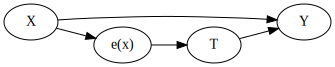

In [6]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")

g

### Propensity Score Estimation


In [7]:
ps_model = smf.logit("""intervention ~ 
tenure + last_engagement_score + department_score
+ C(n_of_reports) + C(gender) + C(role)""", data=df).fit(disp=0)

In [8]:
data_ps = df.assign(
    propensity_score = ps_model.predict(df),
)

data_ps[["intervention", "engagement_score", "propensity_score"]].head()

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


### Propensity Score and Orthogonalization


In [9]:
model = smf.ols("engagement_score ~ intervention + propensity_score",
                data=data_ps).fit()
model.params["intervention"]

0.26331267490277294

### Propensity Score Matching



In [10]:
from sklearn.neighbors import KNeighborsRegressor

T = "intervention"
X = "propensity_score"
Y = "engagement_score"

treated = data_ps.query(f"{T}==1")
untreated = data_ps.query(f"{T}==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]],
                                             untreated[Y])

mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[Y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[[X]])),
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[[X]]))
])

predicted.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,propensity_score,match
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843,0.596106,0.557680
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843,0.391138,-0.952622
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,0.602578,-0.618381
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843,0.580990,-1.404962
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843,0.619976,0.000354


In [11]:
np.mean((predicted[Y] - predicted["match"])*predicted[T] 
        + (predicted["match"] - predicted[Y])*(1-predicted[T]))

0.28777443474045966

### Inverse Propensity Weighting


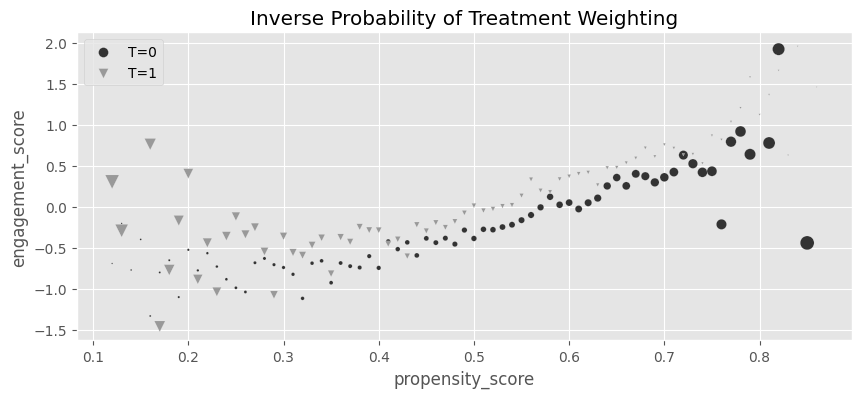

In [12]:
g_data = (data_ps
          .assign(
              weight = data_ps["intervention"]/data_ps["propensity_score"] + (1-data_ps["intervention"])/(1-data_ps["propensity_score"]),
              propensity_score=data_ps["propensity_score"].round(2)
          )
          .groupby(["propensity_score", "intervention"])
          [["weight", "engagement_score"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
for t in [0, 1]:
    sns.scatterplot(data=g_data.query(f"intervention=={t}"), y="engagement_score", x="propensity_score", size="weight",
                    sizes=(1,100), color=color[t], legend=None, label=f"T={t}", marker=marker[t])

plt.title("Inverse Probability of Treatment Weighting")
plt.legend()


In [13]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
t1 = data_ps.query("intervention==1")["engagement_score"] 
t0 = data_ps.query("intervention==0")["engagement_score"] 

y1 = sum(t1*weight_t)/len(data_ps)
y0 = sum(t0*weight_nt)/len(data_ps)

print("E[Y1]:", y1)
print("E[Y0]:", y0)
print("ATE", y1 - y0)

E[Y1]: 0.11656317232946947
E[Y0]: -0.1494155364781463
ATE 0.26597870880761576


In [14]:
np.mean(data_ps["engagement_score"] 
        * (data_ps["intervention"] - data_ps["propensity_score"]) 
        / (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

0.26597870880761576

### Variance of IPW


In [15]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix

# define function that computes the IPW estimator
def est_ate_with_ps(df, ps_formula, T, Y):
    
    X = dmatrix(ps_formula, df)
    ps_model = LogisticRegression(penalty="none",
                                  max_iter=1000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]
    
    # compute the ATE
    return np.mean((df[T]-ps) / (ps*(1-ps)) * df[Y]) 

In [16]:
formula = """tenure + last_engagement_score + department_score
+ C(n_of_reports) + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

est_ate_with_ps(df, formula, T, Y)

0.2660270346691223

In [17]:
from joblib import Parallel, delayed # for parallel processing

def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(data.sample(frac=1, replace=True))
        for _ in range(rounds)
    )
    
    return np.percentile(stats, pcts)

In [18]:
from toolz import partial

print(f"ATE: {est_ate_with_ps(df, formula, T, Y)}")

est_fn = partial(est_ate_with_ps, ps_formula=formula, T=T, Y=Y)
print(f"95% C.I.: ", bootstrap(df, est_fn))

ATE: 0.2660270346691223


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% C.I.:  [0.22653443 0.30071856]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


### Stabilized Propensity Weights


In [19]:
print("Original Sample Size", data_ps.shape[0])
print("Treated Pseudo-Population Sample Size", sum(weight_t))
print("Untreated Pseudo-Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Pseudo-Population Sample Size 10435.089079197905
Untreated Pseudo-Population Sample Size 10354.298899788295


In [20]:
p_of_t = data_ps["intervention"].mean()

t1 = data_ps.query("intervention==1")
t0 = data_ps.query("intervention==0")

weight_t_stable = p_of_t/t1["propensity_score"]
weight_nt_stable = (1-p_of_t)/(1-t0["propensity_score"])

print("Treat size:", len(t1))
print("W treat", sum(weight_t_stable))

print("Control size:", len(t0))
print("W treat", sum(weight_nt_stable))

Treat size: 5611
W treat 5634.80750874597
Control size: 4780
W treat 4763.1169994214115


In [21]:
nt = len(t1)
nc = len(t0)

y1 = sum(t1["engagement_score"]*weight_t_stable)/nt
y0 = sum(t0["engagement_score"]*weight_nt_stable)/nc

print("ATE: ", y1 - y0)

ATE:  0.2659787088076156


### Pseudo-Populations


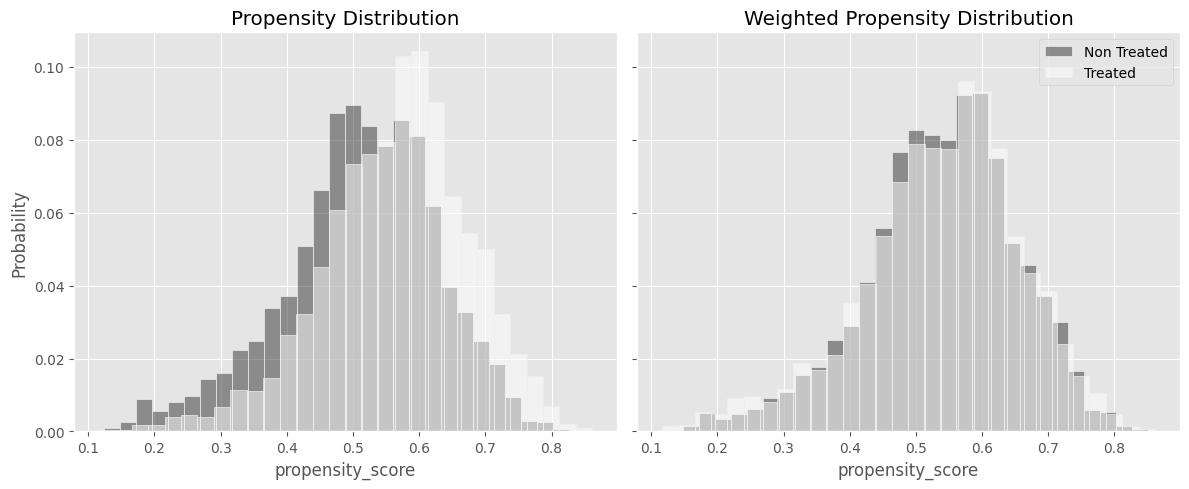

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

sns.histplot(data_ps.query("intervention==0")["propensity_score"], stat="probability",
             label="Not Treated", color="C0", bins=30, ax=ax1, alpha=0.5)
sns.histplot(data_ps.query("intervention==1")["propensity_score"], stat="probability",
             label="Treated", color="C2", alpha=0.5, bins=30, ax=ax1)
ax1.set_title("Propensity Distribution")

sns.histplot(data_ps.query("intervention==0").assign(w=weight_nt_stable),
             x="propensity_score", stat="probability",
             color="C0", weights="w", label="Non Treated", bins=30, ax=ax2,  alpha=0.5)

sns.histplot(data_ps.query("intervention==1").assign(w=weight_t_stable),
             x="propensity_score", stat="probability",
             color="C2", weights="w", label="Treated", bins=30, alpha=0.5, ax=ax2)
ax2.set_title("Weighted Propensity Distribution")
plt.legend()

plt.tight_layout()


### Selection Bias


### Bias-Variance Trade-Off

### Positivity


In [23]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.5, n) > 0

y0 = -x
y1 = y0 + t  # ate of 1

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

df_no_pos.head()

,x,t,y
0,1.624345,1,-0.526442
1,-0.611756,0,0.659516
2,-0.528172,0,0.438549
3,-1.072969,0,0.950810
4,0.865408,1,-0.271397


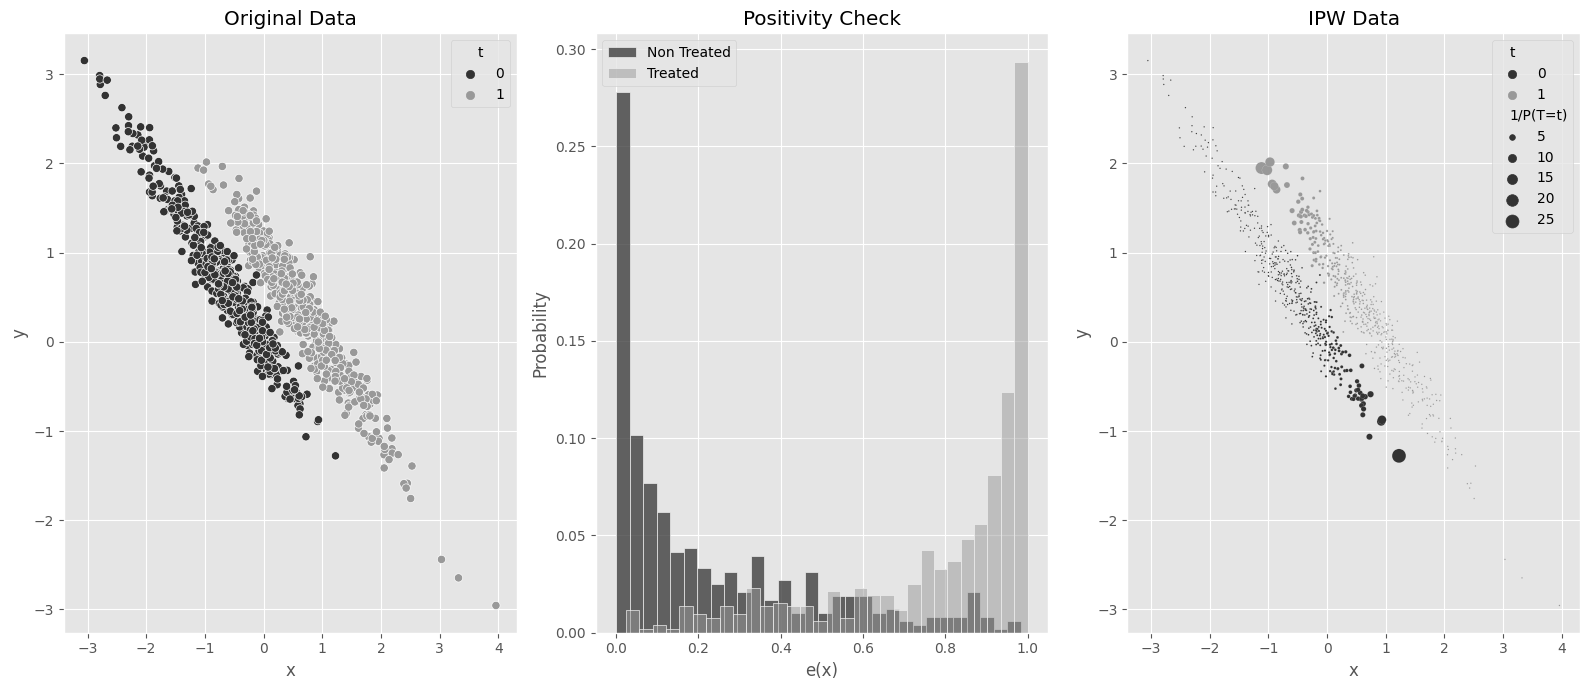

In [24]:
ps_model_sim = smf.logit("""t ~ x""", data=df_no_pos).fit(disp=0)
df_no_pos_ps = df_no_pos.assign(ps=ps_model_sim.predict(df_no_pos))

ps = ps_model_sim.predict(df_no_pos)
w = df_no_pos["t"]*df_no_pos["t"].mean()/ps  + (1-df_no_pos["t"])*((1-df_no_pos["t"].mean())/(1-ps))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,7))

sns.scatterplot(data=df_no_pos_ps.assign(w=w), x="x", y="y", hue="t", ax=ax1);
ax1.set_title("Original Data")

sns.histplot(df_no_pos_ps.query("t==0")["ps"], stat="probability",
             label="Non Treated", color="C0", bins=30, ax=ax2)
sns.histplot(df_no_pos_ps.query("t==1")["ps"], stat="probability",
             label="Treated", color="C1", alpha=0.5, bins=30, ax=ax2)
ax2.set_xlabel("e(x)")
ax2.legend()
ax2.set_title("Positivity Check")

sns.scatterplot(data=df_no_pos_ps.assign(**{"1/P(T=t)":w}), x="x", y="y", hue="t", ax=ax3, size="1/P(T=t)", sizes=(1, 100));
ax3.set_title("IPW Data")

plt.tight_layout()


In [25]:
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")
print("ATE:",  est_fn(df_no_pos))
print(f"95% C.I.: ", bootstrap(df_no_pos, est_fn))

ATE: 0.6478011810615735


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% C.I.:  [0.41710504 0.88840195]


In [26]:
smf.ols("t ~ x + t", data=df_no_pos).fit().params["t"]

0.9999999999999991

## Design vs Model-Based Identification

## Doubly Robust Estimation


In [27]:
from sklearn.linear_model import LinearRegression

def doubly_robust(df, formula, T, Y):
    X = dmatrix(formula, df)
    
    ps_model = LogisticRegression(penalty="none",
                                  max_iter=1000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]
    
    m0 = LinearRegression().fit(X[df[T]==0, :], df.query(f"{T}==0")[Y])
    m1 = LinearRegression().fit(X[df[T]==1, :], df.query(f"{T}==1")[Y])
    
    m0_hat = m0.predict(X)
    m1_hat = m1.predict(X)

    return (
        np.mean(df[T]*(df[Y] - m1_hat)/ps + m1_hat) -
        np.mean((1-df[T])*(df[Y] - m0_hat)/(1-ps) + m0_hat)
    )

In [28]:
formula = """tenure + last_engagement_score + department_score
+ C(n_of_reports) + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

print("DR ATE:", doubly_robust(df, formula, T, Y))

est_fn = partial(doubly_robust, formula=formula, T=T, Y=Y)
print("95% CI", bootstrap(df, est_fn))

DR ATE: 0.2711548752076963


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% CI [0.23013185 0.30525249]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

### Treatment is Easy to Model


In [29]:
np.random.seed(123)

n = 10000
x = np.random.beta(1,1, n).round(2)*2
e = 1/(1+np.exp(-(1+1.5*x)))
t = np.random.binomial(1, e)

y1 = 1
y0 = 1 - 1*x**3
y = t*(y1) + (1-t)*y0 + np.random.normal(0, 1, n)

df_easy_t = pd.DataFrame(dict(y=y, x=x, t=t))

print("True ATE:", np.mean(y1-y0))

True ATE: 2.0056243152


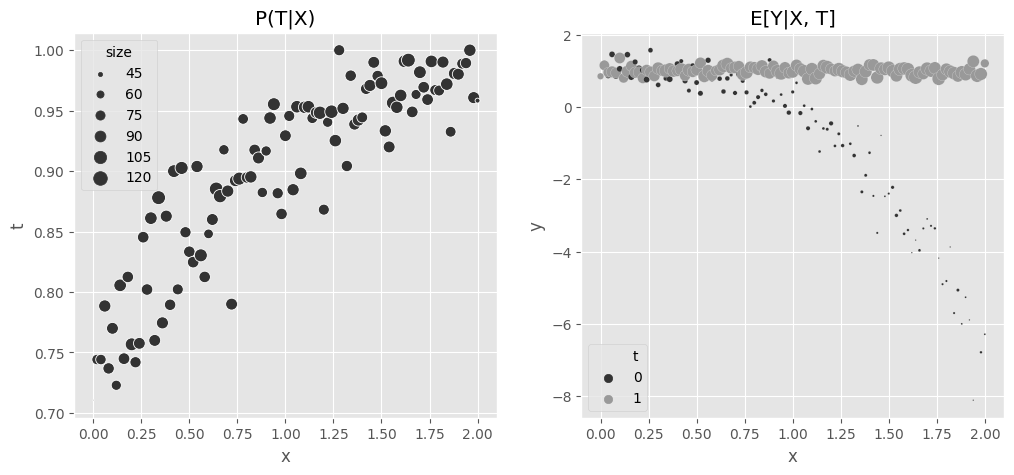

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(data=(df_easy_t
                      .assign(size=1)
                      .groupby(["x"])
                      .agg({"size":"sum", "t":"mean"})
                      .reset_index()),
                x="x", y="t", sizes=(1, 100), size="size", ax=ax1);
ax1.set_title("P(T|X)")

sns.scatterplot(data=(df_easy_t
                      .assign(size=1)
                      .groupby(["x", "t"])
                      .agg({"size":"sum", "y":"mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1, 100), size="size", ax=ax2)

ax2.set_title("E[Y|X, T]")

h,l = ax2.get_legend_handles_labels()
plt.legend(h[0:3],l[0:3])


In [31]:
m0 = smf.ols("y~x", data=df_easy_t.query("t==0")).fit()
m1 = smf.ols("y~x", data=df_easy_t.query("t==1")).fit()
regr_ate = (m1.predict(df_easy_t) - m0.predict(df_easy_t)).mean()

print("Regression ATE:", regr_ate)

Regression ATE: 1.78667839683302


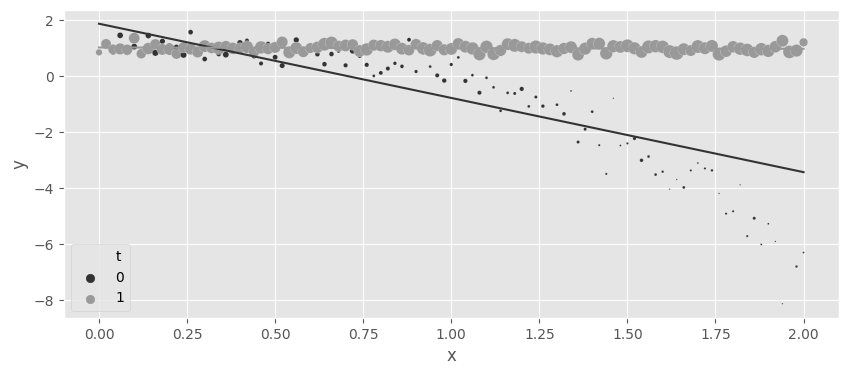

In [32]:
regr = smf.ols("y~x*t", data=df_easy_t).fit()

plt.figure(figsize=(10,4))

sns.scatterplot(data=(df_easy_t
                      .assign(count=1)
                      .groupby(["x", "t"])
                      .agg({"count":"sum", "y":"mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1, 100), size="count");

g = sns.lineplot(data=(df_easy_t
                   .assign(pred=regr.fittedvalues)
                   .groupby(["x", "t"])
                   .mean()
                   .reset_index()),
             x="x", y="pred", hue="t", sizes=(1, 100))

h,l = g.get_legend_handles_labels()
plt.legend(h[0:3],l[0:3])



In [33]:
m = smf.ols("y~t*(x + np.power(x, 3))", data=df_easy_t).fit()
regr_ate = (m.predict(df_easy_t.assign(t=1))
            - m.predict(df_easy_t.assign(t=0))).mean()

print("Regression ATE:", regr_ate)

Regression ATE: 1.997099974718993


In [34]:
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")
print("Propensity Score ATE:", est_fn(df_easy_t))
print("95% CI", bootstrap(df_easy_t, est_fn))

Propensity Score ATE: 2.00235038847401


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% CI [1.80802227 2.22565667]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

In [35]:
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print("DR ATE:", est_fn(df_easy_t))
print("95% CI", bootstrap(df_easy_t, est_fn))

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

DR ATE: 2.0016179342631157


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% CI [1.87088771 2.145382  ]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

### Outcome is Easy to Model


In [36]:
np.random.seed(123)

n = 10000
x = np.random.beta(1,1, n).round(2)*2
e = 1/(1+np.exp(-(2*x - x**3)))
t = np.random.binomial(1, e)

y1 = x
y0 = y1 + 1 # ate of -1
y = t*(y1) + (1-t)*y0 + np.random.normal(0, 1, n)

df_easy_y = pd.DataFrame(dict(y=y, x=x, t=t))

print("True ATE:", np.mean(y1-y0))

True ATE: -1.0


The same kind of plot from before can be used to show the complex functional form for $P(T|X)$ and the simplicity of $E[Y_t|X]$.

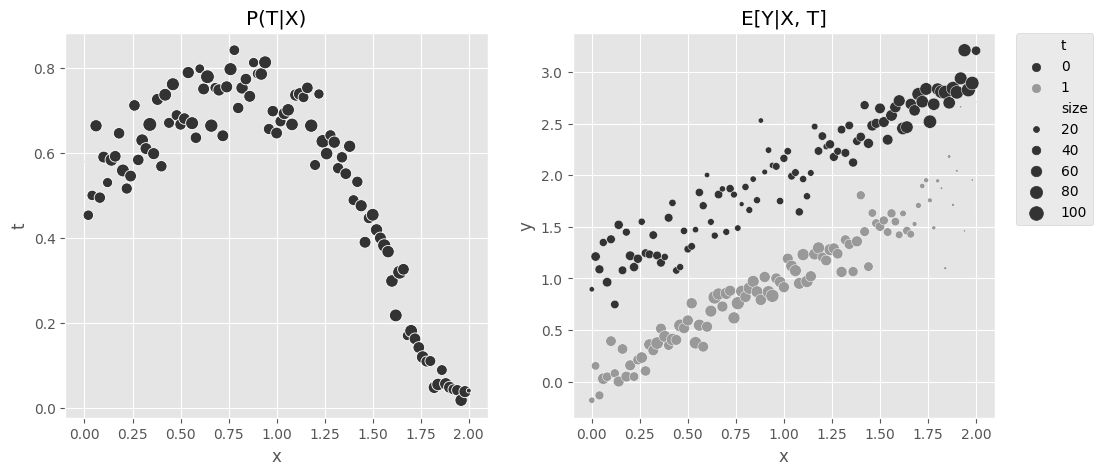

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(data=(df_easy_y
                      .assign(size=1)
                      .groupby(["x"])
                      .agg({"size":"sum", "t":"mean"})
                      .reset_index()),
                x="x", y="t", sizes=(1, 100), size="size", ax=ax1, legend=None);

sns.scatterplot(data=(df_easy_y
                      .assign(size=1)
                      .groupby(["x", "t"])
                      .agg({"size":"sum", "y":"mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1, 100), size="size", ax=ax2);

ax1.set_title("P(T|X)")
ax2.set_title("E[Y|X, T]")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [38]:
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")
print("Propensity Score ATE:", est_fn(df_easy_y))
print("95% CI", bootstrap(df_easy_y, est_fn))

Propensity Score ATE: -1.1042900278680896


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% CI [-1.14326893 -1.06576358]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

In [39]:
m0 = smf.ols("y~x", data=df_easy_y.query("t==0")).fit()
m1 = smf.ols("y~x", data=df_easy_y.query("t==1")).fit()
regr_ate = (m1.predict(df_easy_y) - m0.predict(df_easy_y)).mean()

print("Regression ATE:", regr_ate)

Regression ATE: -1.0008783612504364


In [40]:
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print("DR ATE:", est_fn(df_easy_y))
print("95% CI", bootstrap(df_easy_y, est_fn))

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


DR ATE: -1.002845934780583


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

95% CI [-1.04156952 -0.96353366]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-

## Generalized Propensity Score for Continuous Treatment


In [41]:
df_cont_t = pd.read_csv("./data/interest_rate.csv")

df_cont_t.head()

,ml_1,ml_2,interest,duration
0,0.392938,0.326285,7.1,12.0
1,-0.427721,0.679573,5.6,17.0
2,-0.546297,0.647309,11.1,12.0
3,0.102630,-0.264776,7.2,18.0
4,0.438938,-0.648818,9.5,19.0


In [42]:
m_naive = smf.ols("duration ~ interest", data=df_cont_t).fit()
m_naive.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.5033,0.226,64.283,0.000,14.061,14.946
interest,0.3393,0.029,11.697,0.000,0.282,0.396


In [43]:
model_t = smf.ols("interest~ml_1+ml_2", data=df_cont_t).fit()

In [44]:
def conditional_density(x, mean, std):
    denom = std*np.sqrt(2*np.pi)
    num = np.exp(-((1/2)*((x-mean)/std)**2))
    return (num/denom).ravel()
    

gps = conditional_density(df_cont_t["interest"],
                          model_t.fittedvalues,
                          np.std(model_t.resid))
gps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [45]:
from scipy.stats import norm

gps = norm(loc=model_t.fittedvalues,
           scale=np.std(model_t.resid)).pdf(df_cont_t["interest"])
gps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

:::{admonition} Beyond the Normal
If the treatment follows another distribution other than the normal, you can use generalized linear models (`glm`) to fit it. For example, if $T$ was assigned according to a Poisson distribution, you could build the GPS weights with something like the following code
 
```python
import statsmodels.api as sm
from scipy.stats import poisson
 
mt = smf.glm("t~x1+x2",
             data=df, family=sm.families.Poisson()).fit()
 
gps = poisson(mu=m_pois.fittedvalues).pmf(df["t"])
 
w = 1/gps
```
 
:::
 
 
Using the inverse of the GPS as weights in a regression model can adjust for the bias. You can see that now you'll find a negative effect of interest on duration, which makes more business sense. 

In [46]:
final_model = smf.wls("duration~interest",
                      data=df_cont_t, weights=1/gps).fit()

final_model.params["interest"]

-0.6673977919925813

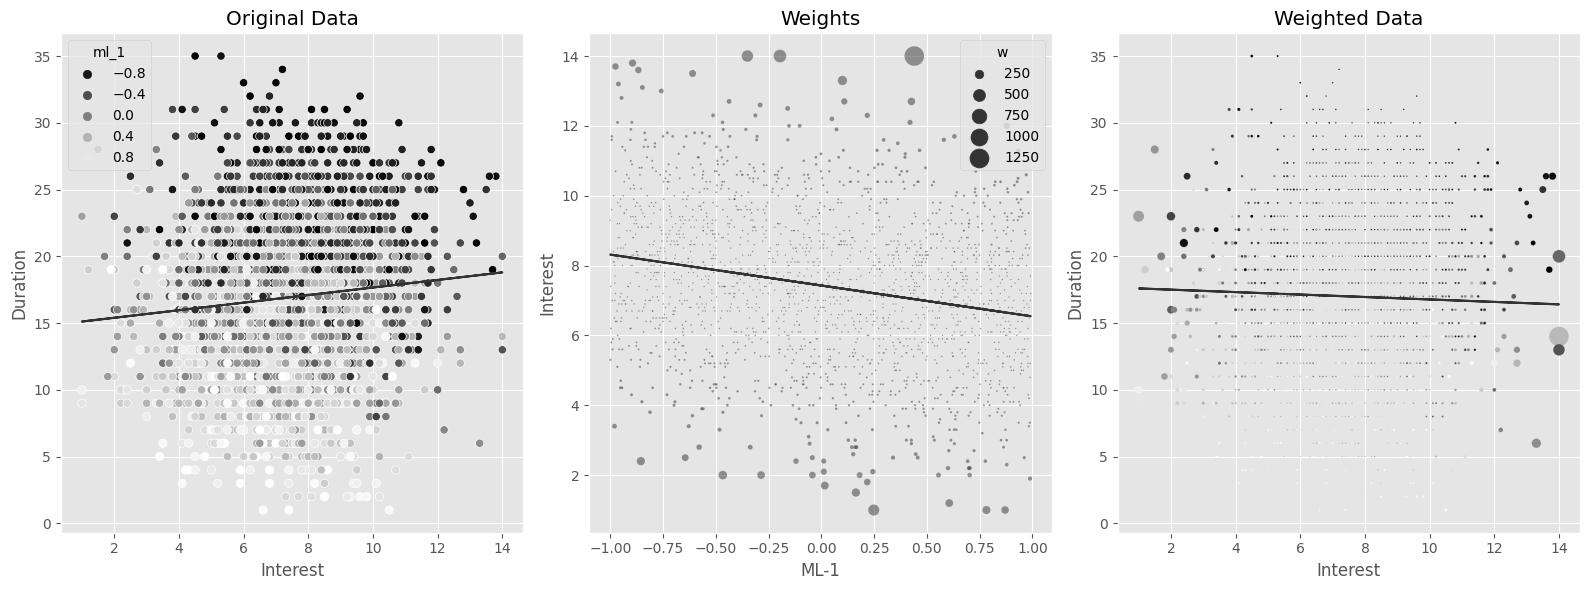

In [47]:
np.random.seed(1)
sample = df_cont_t.sample(2000)



model_ex = smf.ols("interest~ml_1", data=sample).fit()
gps_ex = norm(loc=model_ex.fittedvalues, scale=np.std(model_ex.resid)).pdf(sample["interest"])

w_ex = 1/gps_ex

m = smf.ols("duration~interest", data=sample).fit()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

sns.scatterplot(data=sample, x="interest", y="duration", alpha=1, ax=ax1, hue="ml_1", palette = 'gray')
ax1.plot(sample["interest"], m.fittedvalues)

ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data");


sns.scatterplot(data=sample.assign(w=w_ex), x="ml_1", y="interest",size="w",
                sizes=(1,200), alpha=0.5, ax=ax2)
ax2.plot(sample["ml_1"], model_ex.fittedvalues)
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")


m = smf.wls("duration~interest", data=sample, weights=w_ex).fit()

sns.scatterplot(data=sample.assign(w=w_ex), x="interest", y="duration",size="w",
                sizes=(1,200), alpha=1, ax=ax3, hue="ml_1", legend=None, palette = 'gray')
ax3.plot(sample["interest"], m.fittedvalues)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data")

plt.tight_layout()



In [48]:
stabilizer = norm(
    loc=df_cont_t["interest"].mean(),
    scale=np.std(df_cont_t["interest"] - df_cont_t["interest"].mean())
).pdf(df_cont_t["interest"])

gipw =  stabilizer/gps

print("Original Sample Size:", len(df_cont_t))
print("Effective Stable Weights Sample Size:", sum(gipw))

Original Sample Size: 10000
Effective Stable Weights Sample Size: 9988.195951748605


Text(0.5, 1.0, 'Weighted Data')

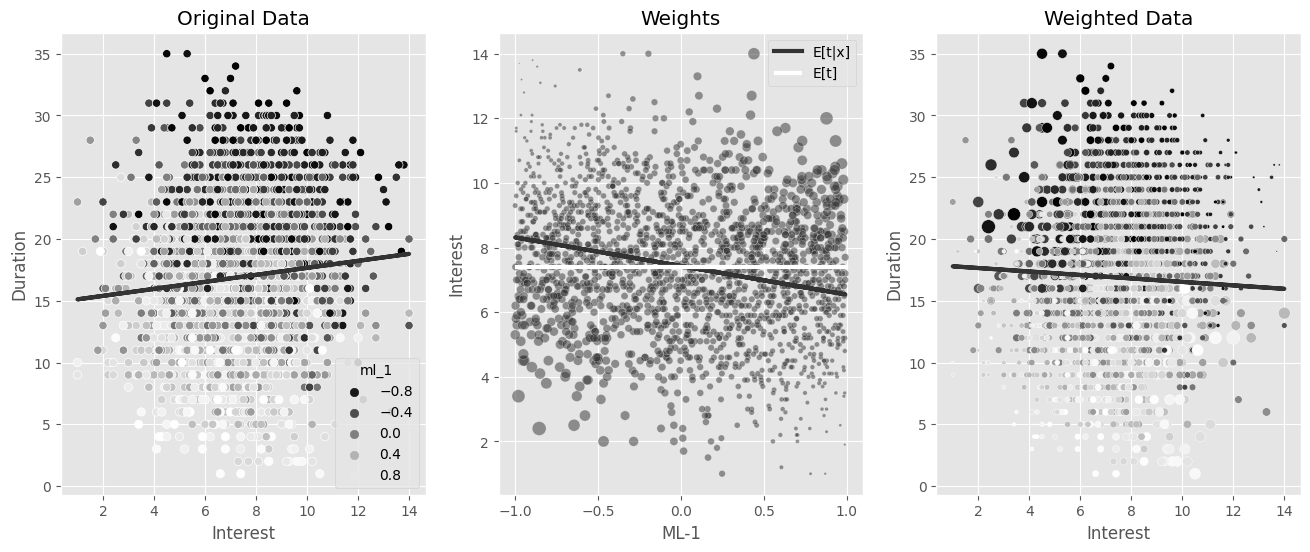

In [49]:
np.random.seed(1)
sample = df_cont_t.sample(2000)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

model_ex = smf.ols("interest~ml_1", data=sample).fit()
gps_ex = norm(loc=model_ex.fittedvalues, scale=np.std(model_ex.resid)).pdf(sample["interest"])
stabilizer_ex = norm(
    loc=sample["interest"].mean(),
    scale=np.std(sample["interest"] - sample["interest"].mean())
).pdf(sample["interest"])


w_ex = stabilizer_ex/gps_ex

m = smf.ols("duration~interest", data=sample).fit()

sns.scatterplot(data=sample, x="interest", y="duration", alpha=1, ax=ax1, hue="ml_1", palette = 'gray')
ax1.plot(sample["interest"], m.fittedvalues, lw=3)
ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data");


sns.scatterplot(data=sample.assign(w=w_ex), x="ml_1", y="interest",size="w",
                sizes=(1,100), alpha=0.5, ax=ax2)

ax2.plot(sample["ml_1"], model_ex.fittedvalues, label="E[t|x]", lw=3)

ax2.hlines(sample["interest"].mean(), -1, 1, label="E[t]", color="C2", lw=3)
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")

h,l = ax2.get_legend_handles_labels()
ax2.legend(h[5:],l[5:],)

m = smf.wls("duration~interest", data=sample, weights=w_ex).fit()

sns.scatterplot(data=sample.assign(w=w_ex), x="interest", y="duration",size="w",
                sizes=(1,100), alpha=1, ax=ax3, hue="ml_1", legend=None, palette = 'gray')
ax3.plot(sample["interest"], m.fittedvalues, lw=3)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data")



In [50]:
final_model = smf.wls("duration ~ interest",
                      data=df_cont_t, weights=gipw).fit()

final_model.params["interest"]

-0.7787046278134059

In [51]:
def gps_normal_ate(df, formula, T, Y, stable=True):
    mt = smf.ols(f"{T}~"+formula, data=df).fit()
    gps = norm(loc=mt.fittedvalues, scale=np.std(mt.resid)).pdf(df[T])
    stabilizer = norm(
        loc=df[T].mean(),
        scale=np.std(df[T] - df[T].mean())
    ).pdf(df[T])
    
    if stable:
        return smf.wls(f"{Y}~{T}", data=df, weights=stabilizer/gps).fit().params[T]
    else:
        return smf.wls(f"{Y}~{T}", data=df, weights=1/gps).fit().params[T]

print("95% CI, non-stable: ", bootstrap(df_cont_t, partial(gps_normal_ate, formula="ml_1 + ml_2", T="interest", Y="duration", stable=False)))
print("95% CI, stable: ", bootstrap(df_cont_t, partial(gps_normal_ate, formula="ml_1 + ml_2", T="interest", Y="duration")))

95% CI, non-stable:  [-0.81074164 -0.52605933]
95% CI, stable:  [-0.85834311 -0.71001914]


## Keys Ideas


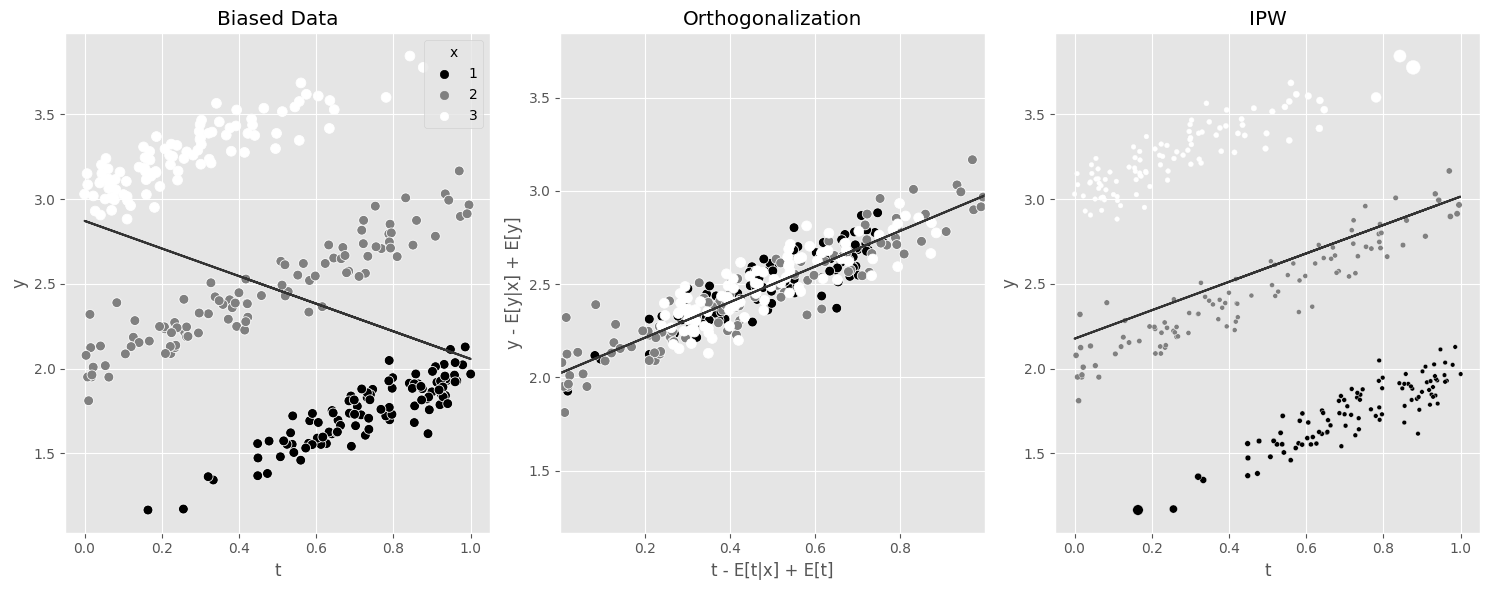

In [52]:
np.random.seed(1)

n=100

df1 = pd.DataFrame(dict(
    x=1,
    t=np.random.beta(2.5,1, n),
)).assign(y = lambda d: np.random.normal(d["x"]+d["t"], 0.1))

df2 = pd.DataFrame(dict(
    x=2,
    t=np.random.beta(1,1, n),
)).assign(y = lambda d: np.random.normal(d["x"]+d["t"], 0.1))

df3 = pd.DataFrame(dict(
    x=3,
    t=np.random.beta(1,2.5, n),
)).assign(y = lambda d: np.random.normal(d["x"]+d["t"], 0.1))


df_example = pd.concat([df1, df2, df3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))

m = smf.ols("y~t", data=df_example).fit()
sns.scatterplot(data=df_example, x="t", y="y",  hue="x", s=50, ax=ax1, palette = 'gray')
ax1.plot(df_example["t"], m.fittedvalues)
ax1.set_title("Biased Data")

## Orthogonalization

mt = smf.ols("t~x", data=df_example).fit()
my = smf.ols("y~x", data=df_example).fit()

df_ex_res = df_example.assign(
    t_res = mt.resid + df_example["t"].mean(),
    y_res = my.resid + df_example["y"].mean()
)

m_final = smf.ols("y_res~t_res", data=df_ex_res).fit()
sns.scatterplot(data=df_ex_res, x="t_res", y="y_res",  hue="x", s=50, ax=ax2, legend=None, palette = 'gray')
ax2.plot(df_ex_res["t_res"], m_final.fittedvalues)

ax2.set_ylim(df_example["y"].min(), df_example["y"].max())
ax2.set_xlim(df_example["t"].min(), df_example["t"].max())

ax2.set_ylabel("y - E[y|x] + E[y]")
ax2.set_xlabel("t - E[t|x] + E[t]")
ax2.set_title("Orthogonalization")


## IPW
gps_example = norm(loc=mt.fittedvalues, scale=np.std(mt.resid)).pdf(df_example["t"])
stabilizer_example = norm(
    loc=df_example["t"].mean(),
    scale=np.std(df_example["t"] - df_example["t"].mean())
).pdf(df_example["t"])


w_example = stabilizer_example/gps_example
mw = smf.wls("y~t", data=df_example, weights=w_example).fit()


sns.scatterplot(data=df_example.assign(w=w_example), x="t", y="y",  hue="x", ax=ax3, size="w",
                legend=None, sizes=(11,100), palette = 'gray')
ax3.plot(df_example["t"], mw.fittedvalues)
ax3.set_title("IPW")

plt.tight_layout()
